In [118]:
import io
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, ViTForImageClassification, Trainer, TrainingArguments
from datasets import Dataset, Image, ClassLabel
import evaluate

In [151]:
label_path = "/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/average_labels.csv"
df = pd.read_csv(label_path)
image_dir = "/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images_average"
df['image'] = df['FileName'].apply(lambda x: os.path.join(image_dir, x))
df["label"] = df["Label"].astype("category")
df = df.drop(columns=["Label", "FileName"])
unique_labels = set(df["label"])
class_label = ClassLabel(names=list(unique_labels))

In [152]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())
dataset = dataset.cast_column("label", class_label)


Casting the dataset:   0%|          | 0/324 [00:00<?, ? examples/s]

In [153]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 324
})

In [154]:
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224", use_fast=True)

In [155]:
def transform_for_model(example):
    example['pixel_values'] = [image.convert("RGB") for image in example['image']]
    example['pixel_values'] = processor(example['pixel_values'], return_tensors='pt')["pixel_values"]
    return example

dataset = dataset.map(transform_for_model, batched=True)

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

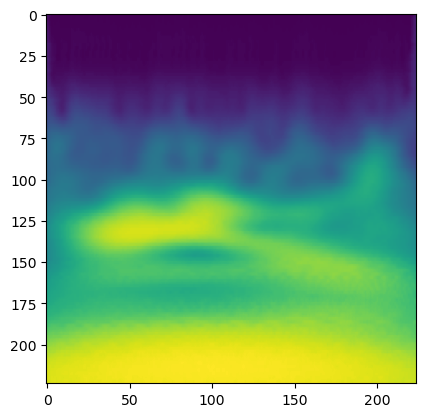

In [156]:
plt.imshow(dataset['pixel_values'][0][1])

In [157]:
dataset = dataset.train_test_split(test_size=0.1, stratify_by_column="label", seed=42)

In [158]:
model_checkpoint = "google/vit-base-patch16-224"
num_classes = len(unique_labels)
model = ViTForImageClassification.from_pretrained(
    model_checkpoint,
    ignore_mismatched_sizes=True,
    num_labels=num_classes
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [159]:
for name, p in model.named_parameters():
    if not name.startswith("classifier"):
        p.requires_grad = False

In [160]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,800,963 | trainable_params = 2,307


In [161]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetune_test",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16, 
    num_train_epochs=50,
    warmup_ratio=0.1,
    logging_steps=10,
    metric_for_best_model='accuracy',
    push_to_hub=True
)


In [ ]:
metric = evaluate.load("accuracy")
# need to get some more scores in here, like the f1 score etc. 


def compute_metrics(eval_pred):
    """Compute accuracy on the batch"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [163]:
def collate_fn(examples):
    pixel_values = torch.stack([torch.tensor(example["pixel_values"]) for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [164]:
trainer = Trainer(
    model,
    args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [165]:
train_results = trainer.train()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0744363069534302, 'eval_accuracy': 0.48484848484848486, 'eval_runtime': 2.027, 'eval_samples_per_second': 16.28, 'eval_steps_per_second': 1.48, 'epoch': 0.84}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0742919445037842, 'eval_accuracy': 0.48484848484848486, 'eval_runtime': 2.0145, 'eval_samples_per_second': 16.381, 'eval_steps_per_second': 1.489, 'epoch': 1.89}
{'loss': 1.1173, 'grad_norm': 2.0224523544311523, 'learning_rate': 2.5e-05, 'epoch': 2.11}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0744578838348389, 'eval_accuracy': 0.5151515151515151, 'eval_runtime': 2.0197, 'eval_samples_per_second': 16.339, 'eval_steps_per_second': 1.485, 'epoch': 2.95}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0750426054000854, 'eval_accuracy': 0.5151515151515151, 'eval_runtime': 2.0335, 'eval_samples_per_second': 16.228, 'eval_steps_per_second': 1.475, 'epoch': 4.0}
{'loss': 1.1109, 'grad_norm': 1.7684694528579712, 'learning_rate': 5e-05, 'epoch': 4.21}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0759661197662354, 'eval_accuracy': 0.5151515151515151, 'eval_runtime': 2.0135, 'eval_samples_per_second': 16.389, 'eval_steps_per_second': 1.49, 'epoch': 4.84}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0771169662475586, 'eval_accuracy': 0.48484848484848486, 'eval_runtime': 1.9882, 'eval_samples_per_second': 16.598, 'eval_steps_per_second': 1.509, 'epoch': 5.89}
{'loss': 1.1049, 'grad_norm': 1.7287123203277588, 'learning_rate': 4.722222222222222e-05, 'epoch': 6.32}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.078105092048645, 'eval_accuracy': 0.5151515151515151, 'eval_runtime': 2.0192, 'eval_samples_per_second': 16.343, 'eval_steps_per_second': 1.486, 'epoch': 6.95}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0786572694778442, 'eval_accuracy': 0.5151515151515151, 'eval_runtime': 2.0077, 'eval_samples_per_second': 16.437, 'eval_steps_per_second': 1.494, 'epoch': 8.0}
{'loss': 1.1019, 'grad_norm': 3.0935771465301514, 'learning_rate': 4.4444444444444447e-05, 'epoch': 8.42}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0790163278579712, 'eval_accuracy': 0.5151515151515151, 'eval_runtime': 2.0062, 'eval_samples_per_second': 16.449, 'eval_steps_per_second': 1.495, 'epoch': 8.84}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.079762578010559, 'eval_accuracy': 0.5151515151515151, 'eval_runtime': 2.0371, 'eval_samples_per_second': 16.2, 'eval_steps_per_second': 1.473, 'epoch': 9.89}
{'loss': 1.101, 'grad_norm': 1.0885742902755737, 'learning_rate': 4.166666666666667e-05, 'epoch': 10.53}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0802478790283203, 'eval_accuracy': 0.45454545454545453, 'eval_runtime': 2.0583, 'eval_samples_per_second': 16.033, 'eval_steps_per_second': 1.458, 'epoch': 10.95}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0806865692138672, 'eval_accuracy': 0.45454545454545453, 'eval_runtime': 2.0501, 'eval_samples_per_second': 16.097, 'eval_steps_per_second': 1.463, 'epoch': 12.0}
{'loss': 1.0985, 'grad_norm': 2.010505199432373, 'learning_rate': 3.888888888888889e-05, 'epoch': 12.63}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.081024169921875, 'eval_accuracy': 0.45454545454545453, 'eval_runtime': 1.9941, 'eval_samples_per_second': 16.549, 'eval_steps_per_second': 1.504, 'epoch': 12.84}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0812979936599731, 'eval_accuracy': 0.45454545454545453, 'eval_runtime': 2.1537, 'eval_samples_per_second': 15.322, 'eval_steps_per_second': 1.393, 'epoch': 13.89}
{'loss': 1.0906, 'grad_norm': 2.7387170791625977, 'learning_rate': 3.611111111111111e-05, 'epoch': 14.74}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0817503929138184, 'eval_accuracy': 0.48484848484848486, 'eval_runtime': 2.1288, 'eval_samples_per_second': 15.502, 'eval_steps_per_second': 1.409, 'epoch': 14.95}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0822864770889282, 'eval_accuracy': 0.45454545454545453, 'eval_runtime': 2.0928, 'eval_samples_per_second': 15.768, 'eval_steps_per_second': 1.433, 'epoch': 16.0}
{'loss': 1.0919, 'grad_norm': 2.164470672607422, 'learning_rate': 3.3333333333333335e-05, 'epoch': 16.84}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.08287513256073, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 1.9899, 'eval_samples_per_second': 16.584, 'eval_steps_per_second': 1.508, 'epoch': 16.84}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.083270788192749, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 2.0172, 'eval_samples_per_second': 16.359, 'eval_steps_per_second': 1.487, 'epoch': 17.89}
{'loss': 1.0931, 'grad_norm': 4.252094745635986, 'learning_rate': 3.055555555555556e-05, 'epoch': 18.95}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0835399627685547, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 2.0223, 'eval_samples_per_second': 16.318, 'eval_steps_per_second': 1.483, 'epoch': 18.95}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0836670398712158, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 2.168, 'eval_samples_per_second': 15.221, 'eval_steps_per_second': 1.384, 'epoch': 20.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0839542150497437, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 1.9735, 'eval_samples_per_second': 16.721, 'eval_steps_per_second': 1.52, 'epoch': 20.84}
{'loss': 1.0907, 'grad_norm': 4.170568943023682, 'learning_rate': 2.777777777777778e-05, 'epoch': 21.05}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0842937231063843, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 2.0586, 'eval_samples_per_second': 16.03, 'eval_steps_per_second': 1.457, 'epoch': 21.89}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0845160484313965, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 1.9922, 'eval_samples_per_second': 16.565, 'eval_steps_per_second': 1.506, 'epoch': 22.95}
{'loss': 1.0874, 'grad_norm': 1.7092382907867432, 'learning_rate': 2.5e-05, 'epoch': 23.16}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.084599494934082, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 2.0176, 'eval_samples_per_second': 16.356, 'eval_steps_per_second': 1.487, 'epoch': 24.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0846526622772217, 'eval_accuracy': 0.3939393939393939, 'eval_runtime': 2.0318, 'eval_samples_per_second': 16.242, 'eval_steps_per_second': 1.477, 'epoch': 24.84}
{'loss': 1.0868, 'grad_norm': 1.5609445571899414, 'learning_rate': 2.2222222222222223e-05, 'epoch': 25.26}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0847896337509155, 'eval_accuracy': 0.45454545454545453, 'eval_runtime': 2.061, 'eval_samples_per_second': 16.011, 'eval_steps_per_second': 1.456, 'epoch': 25.89}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0850638151168823, 'eval_accuracy': 0.45454545454545453, 'eval_runtime': 2.201, 'eval_samples_per_second': 14.993, 'eval_steps_per_second': 1.363, 'epoch': 26.95}
{'loss': 1.0876, 'grad_norm': 1.9329781532287598, 'learning_rate': 1.9444444444444445e-05, 'epoch': 27.37}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0854465961456299, 'eval_accuracy': 0.42424242424242425, 'eval_runtime': 2.012, 'eval_samples_per_second': 16.401, 'eval_steps_per_second': 1.491, 'epoch': 28.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0857868194580078, 'eval_accuracy': 0.42424242424242425, 'eval_runtime': 2.0325, 'eval_samples_per_second': 16.236, 'eval_steps_per_second': 1.476, 'epoch': 28.84}
{'loss': 1.0821, 'grad_norm': 2.878284454345703, 'learning_rate': 1.6666666666666667e-05, 'epoch': 29.47}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.086053490638733, 'eval_accuracy': 0.42424242424242425, 'eval_runtime': 2.0484, 'eval_samples_per_second': 16.11, 'eval_steps_per_second': 1.465, 'epoch': 29.89}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0864222049713135, 'eval_accuracy': 0.42424242424242425, 'eval_runtime': 2.0379, 'eval_samples_per_second': 16.193, 'eval_steps_per_second': 1.472, 'epoch': 30.95}
{'loss': 1.0873, 'grad_norm': 1.7278839349746704, 'learning_rate': 1.388888888888889e-05, 'epoch': 31.58}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0866491794586182, 'eval_accuracy': 0.42424242424242425, 'eval_runtime': 2.026, 'eval_samples_per_second': 16.288, 'eval_steps_per_second': 1.481, 'epoch': 32.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0867313146591187, 'eval_accuracy': 0.42424242424242425, 'eval_runtime': 2.0332, 'eval_samples_per_second': 16.23, 'eval_steps_per_second': 1.475, 'epoch': 32.84}
{'loss': 1.0847, 'grad_norm': 2.0523669719696045, 'learning_rate': 1.1111111111111112e-05, 'epoch': 33.68}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0868040323257446, 'eval_accuracy': 0.42424242424242425, 'eval_runtime': 2.2104, 'eval_samples_per_second': 14.93, 'eval_steps_per_second': 1.357, 'epoch': 33.89}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0867265462875366, 'eval_accuracy': 0.42424242424242425, 'eval_runtime': 2.0493, 'eval_samples_per_second': 16.103, 'eval_steps_per_second': 1.464, 'epoch': 34.95}
{'loss': 1.0848, 'grad_norm': 2.2312047481536865, 'learning_rate': 8.333333333333334e-06, 'epoch': 35.79}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.086736798286438, 'eval_accuracy': 0.42424242424242425, 'eval_runtime': 2.043, 'eval_samples_per_second': 16.153, 'eval_steps_per_second': 1.468, 'epoch': 36.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.0867202281951904, 'eval_accuracy': 0.42424242424242425, 'eval_runtime': 2.0029, 'eval_samples_per_second': 16.476, 'eval_steps_per_second': 1.498, 'epoch': 36.84}


KeyboardInterrupt: 

In [166]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)

  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.086739182472229, 'eval_accuracy': 0.42424242424242425, 'eval_runtime': 2.0281, 'eval_samples_per_second': 16.272, 'eval_steps_per_second': 1.479, 'epoch': 37.47}
***** eval metrics *****
  epoch                   =    37.4737
  eval_accuracy           =     0.4242
  eval_loss               =     1.0867
  eval_runtime            = 0:00:02.02
  eval_samples_per_second =     16.272
  eval_steps_per_second   =      1.479


In [142]:
trainer.push_to_hub()

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1740499115.Ciprians-MacBook-Pro.local.72669.3:   0%|          | 0.00/405 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

events.out.tfevents.1740498930.Ciprians-MacBook-Pro.local.72669.2:   0%|          | 0.00/6.52k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/CEBangu/vit-base-patch16-224-finetune_test/commit/c131dc2fa7b018d243fac5c179b2f3fd685af11d', commit_message='End of training', commit_description='', oid='c131dc2fa7b018d243fac5c179b2f3fd685af11d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/CEBangu/vit-base-patch16-224-finetune_test', endpoint='https://huggingface.co', repo_type='model', repo_id='CEBangu/vit-base-patch16-224-finetune_test'), pr_revision=None, pr_num=None)